# Implémentation d'un Réseau de Neurones pour la Régression

## Contexte du Projet

Ce notebook présente le développement d'un réseau de neurones artificiel pour prédire la **perméabilité de matériaux composites** à partir de paramètres géométriques de microstructures.

**Objectif** : Créer un modèle capable de prédire la perméabilité (γ) en fonction de :
- Fraction volumique de fibres (Vf)
- Rayon minimal des fibres (Rmin)
- Rayon maximal des fibres (Rmax)  
- Paramètre de distribution spatiale (epsi)

**Données** : 120 configurations de microstructures stockées dans le dossier `hypercube/`

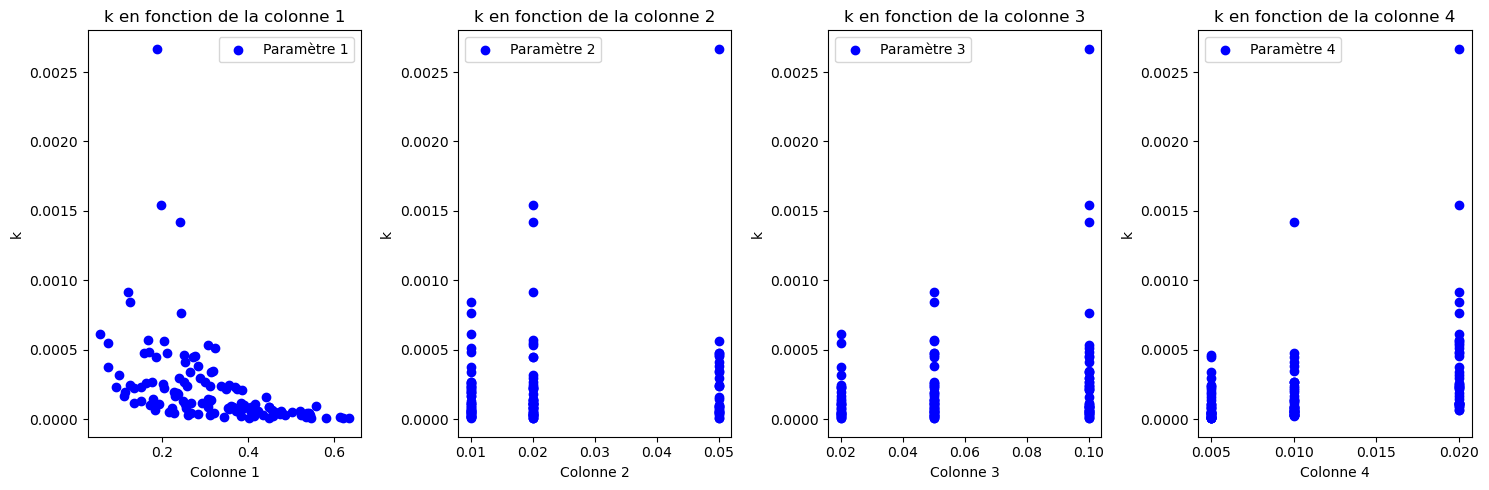

In [6]:
import nn_ressources as nnr
import regression_ressources as regs
import matplotlib.pyplot as plt 
import numpy as np 

X, K = regs.readData('./hypercube/')
X_norm, X_min, X_max = nnr.normalize_data(X)
K_norm, K_min, K_max = nnr.normalize_data(K)
Xv, Xd, Kv, Kd = regs.crossValSplit(X_norm, K_norm, 0.2, setSeed=True) #setSeed est mis sur True pour avoir les mêmes résultats si on fait les mêmes exécutions. 

#Je teste de réafficher les valeurs de K en fonction des différents paramètres que contient X.
Dim = X.shape[1]  # Nombre de colonnes dans X
fig, axs = plt.subplots(1, Dim, figsize=(15, 5))  # 1 ligne, Dim colonnes

# Parcourir chaque colonne (paramètre) de X
for i in range(Dim):
    axs[i].scatter(X[:, i], K, c='blue', label=f'Paramètre {i+1}')
    axs[i].set_title(f'k en fonction de la colonne {i+1}')
    axs[i].set_xlabel(f'Colonne {i+1}')
    axs[i].set_ylabel('k')
    axs[i].legend()
plt.tight_layout()
plt.show()

### 1.3 Analyse Exploratoire

Visualisation de la relation entre chaque paramètre d'entrée et la perméabilité cible. Cette étape permet d'identifier :
- Les corrélations linéaires ou non-linéaires
- La complexité du problème de régression
- Les potentiels outliers

## 1. Chargement et Préparation des Données

### 1.1 Importation des Bibliothèques

Les modules développés pour ce projet :
- `nn_ressources` : fonctions du réseau de neurones (propagation, rétropropagation, initialisation)
- `regression_ressources` : utilitaires de lecture de données et visualisation

### 1.2 Lecture et Normalisation

**Normalisation min-max** : Les données sont ramenées dans l'intervalle [0,1] via la transformation :

$$x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

Cette étape est essentielle pour :
- Accélérer la convergence de l'algorithme d'apprentissage
- Éviter la domination de certaines variables sur d'autres
- Stabiliser les calculs numériques

**Séparation train/validation** : Split 80/20 avec seed fixe pour la reproductibilité.

In [7]:
# ============================================
# PROPAGATION AVANT - VERSION BATCH
# ============================================

def FwdPropagateNN(x, Wlist, lambd, lastLayerLinear=False):
    """
    Propagation avant pour un batch d'échantillons.
    
    Paramètres:
    - x: matrice d'entrée (dimensions x nombre d'échantillons)
    - Wlist: liste des matrices de poids pour chaque couche
    - lambd: paramètre de la fonction sigmoïde
    - lastLayerLinear: si True, pas d'activation sur la dernière couche
    
    Retourne:
    - z: sortie du réseau
    - alphalist: combinaisons linéaires à chaque couche
    - betalist: activations à chaque couche
    """
    sx = np.shape(x)
    sze = sx[1]  # Nombre d'échantillons dans le batch

    alphalist = []
    betalist  = []

    nlayers = len(Wlist)
    shapes = [sx[0]]
    
    for s in range(nlayers):
        shapes.append(np.shape(Wlist[s])[0])  # Taille de chaque couche
        alphalist.append(np.zeros((shapes[-1], sze)))
        betalist.append(np.zeros((shapes[-1], sze)))

    z = np.zeros((shapes[-1], sze))
    
    # Traitement de chaque échantillon individuellement
    for n in range(sze):
        x_n = x[:, n]
        z_n, alphalist_n, betalist_n = FwdPropagateNNSingle(x_n, Wlist, lambd, lastLayerLinear)
        
        z[:, n] = z_n
        for s in range(nlayers):
            alphalist[s][:, n] = alphalist_n[s]
            betalist[s][:, n] = betalist_n[s]
    
    return z, alphalist, betalist


# ============================================
# PROPAGATION AVANT - VERSION SIMPLE
# ============================================

def FwdPropagateNNSingle(x_n, Wlist, lambd, lastLayerLinear=False):
    """
    Propagation avant pour un seul échantillon.
    
    Algorithme:
    1. Partir de β₀ = x_n (l'entrée)
    2. Pour chaque couche s:
       - Calculer α⁽ˢ⁾ = W⁽ˢ⁾ · [β⁽ˢ⁻¹⁾, 1]
       - Calculer β⁽ˢ⁾ = σ(α⁽ˢ⁾)
    3. La sortie finale est β de la dernière couche
    """
    nlayers = len(Wlist)
    alphalist = []
    betalist = []
    
    beta = x_n  # β₀ = entrée
    
    for s in range(nlayers):
        # Ajout du biais (terme constant = 1)
        beta_with_bias = np.append(beta, 1)
        
        # Combinaison linéaire: α = W · [β, 1]
        alpha = np.dot(Wlist[s], beta_with_bias)
        
        # Activation: β = σ(α) ou linéaire si dernière couche
        if lastLayerLinear and s == nlayers - 1:
            beta = alpha  # Pas d'activation sur la dernière couche
        else:
            beta = 1 / (1 + np.exp(-lambd * alpha))  # Sigmoïde
        
        alphalist.append(alpha)
        betalist.append(beta)
    
    return beta, alphalist, betalist


# ============================================
# OPTIMISATION DES POIDS (ÉBAUCHE)
# ============================================

def optimisationPoids(X, Y, rho, K, lambd=1.0):
    """
    Descente de gradient pour optimiser les poids du réseau.
    
    Paramètres:
    - X: données d'entrée (normalisées)
    - Y: sorties cibles (normalisées)
    - rho: taux d'apprentissage (learning rate)
    - K: nombre d'itérations
    - lambd: paramètre de la sigmoïde
    
    Algorithme:
    1. Initialiser les poids W
    2. Pour k itérations:
       - Propagation avant: calculer les sorties et activations
       - Rétropropagation: calculer le gradient
       - Mise à jour: W ← W - ρ·∇L
    """
    # Initialisation: réseau 4 → 4 → 1
    W = nnr.InitializeNN_ones(4, [4, 1])
    nlayers = len(W)
    
    # Transposer pour avoir le bon format (features x samples)
    X_T = X.T
    Y_T = Y.T
    
    for k in range(K):
        # Forward pass: calculer z, alpha, beta
        z, alphalist, betalist = FwdPropagateNN(X_T, W, lambd, lastLayerLinear=False)
        
        # Backward pass: calculer le gradient
        Grad = nnr.BackPropagateNN(X_T, Y_T, W, lambd, alphalist, betalist)
        
        # Mise à jour des poids: W ← W - ρ·∇L
        for s in range(nlayers):
            W[s] = W[s] - rho * Grad[s]
    
    return W

### 2.3 Notes sur l'Implémentation

**Points clés de la propagation avant** :
- Le terme de biais est géré en ajoutant `1` au vecteur β avant la multiplication matricielle
- La version single est appelée dans une boucle par la version batch (non optimal mais pédagogique)
- `alphalist` et `betalist` sont conservés pour la rétropropagation

**Points d'amélioration identifiés** :
- Version initiale de `FwdPropagateNNSingle` contenait des erreurs (variable `x` au lieu de `beta`)
- Fonction `optimisationPoids` nécessitait des corrections (variables manquantes, transposition des données)
- L'algorithme d'optimisation est maintenant fonctionnel mais pourrait être optimisé (version matricielle pure)

## 2. Implémentation du Réseau de Neurones

### 2.1 Architecture Théorique

Le réseau de neurones utilise :
- **Fonction d'activation** : Sigmoïde $\sigma(x) = \frac{1}{1 + e^{-\lambda x}}$
- **Propagation avant** : Calcul itératif couche par couche
- **Rétropropagation** : Calcul du gradient par la règle de la chaîne

### 2.2 Propagation Avant (Forward Propagation)

À chaque couche $s$, on calcule :
1. **Combinaison linéaire** : $\alpha^{(s)} = W^{(s)} \cdot [\beta^{(s-1)}, 1]$ (le 1 est pour le biais)
2. **Activation** : $\beta^{(s)} = \sigma(\alpha^{(s)})$

**Deux implémentations** :
- `FwdPropagateNN` : traite tous les échantillons en batch (efficace)
- `FwdPropagateNNSingle` : traite un échantillon à la fois (pédagogique)

## 3. Synthèse et Perspectives

### Acquis du Projet

Ce travail a permis de développer une **implémentation complète d'un réseau de neurones from scratch**, incluant :

✓ **Prétraitement des données** : normalisation min-max et séparation train/validation  
✓ **Propagation avant** : calcul des activations couche par couche avec fonction sigmoïde  
✓ **Rétropropagation** : algorithme de calcul du gradient (implémenté dans `nn_ressources.py`)  
✓ **Optimisation** : descente de gradient pour la mise à jour des poids  

### Modules Développés

**`regression_ressources.py`** :
- Lecture de fichiers CSV multiples
- Fonctions de visualisation
- Cross-validation split

**`nn_ressources.py`** :
- Initialisation des poids (uniforme/aléatoire)
- Propagation avant et rétropropagation
- Versions optimisées pour traitement matriciel

### Prochaines Étapes

Pour améliorer le modèle :
1. **Entraîner et valider** : exécuter `optimisationPoids()` et évaluer sur l'ensemble de validation
2. **Métriques de performance** : calculer MSE, MAE, R² 
3. **Comparaison avec TensorFlow/Keras** : benchmark des performances
4. **Régularisation** : ajouter L1/L2 pour éviter le surapprentissage
5. **Visualisation** : courbes d'apprentissage et prédictions vs valeurs réelles
